In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import os
import copy
from run_config import Run_types, Run_settings

from pytorch3d_utils import (
    mitsuba_scene_to_torch_3d_no_ground, 
    where, 
    add_background_batch, 
    get_body_image_from_mesh,
    get_scenes_filenames,
    get_background_filenames,
    pose_loss_single_human,
    pose_loss_single_human_full_fail,
    pose_loss_detection_distance
)


import torch
import matplotlib.pyplot as plt
import xml.dom.minidom
from skimage.io import imread
from skimage import img_as_ubyte
from pyrr import Matrix44, Vector4, Vector3
import pyrr

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, 
    BlendParams,
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    HardPhongShader,
    SoftSilhouetteShader
)


from pytorch3d.renderer.cameras import look_at_view_transform

from torch_openpose.body import Body
from torch_openpose import util
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

from tqdm import tqdm
import torch.nn as nn
import imageio
import cv2
import copy
import glob
import random

import wandb

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
import pytorch3d

In [2]:
def get_image_and_score(
        test_mesh, 
        test_camera,
        test_opt, 
        texTshirt, 
        texOther, 
        body_estimation, 
        renderer,
        silhouette_renderer,
        orig_shape = (512, 512, 3)
    ):
    test_backgrounds = get_background_filenames('../data/backgrounds/test/')
    test_background = random.sample(test_backgrounds, 1)[0]
    (canvas_orig, 
     candidate_orig,
     subset_orig,
     heatmap_avg_orig,
     paf_avg_orig) = get_body_image_from_mesh(
        test_mesh, 
        body_estimation, 
        renderer,         
        silhouette_renderer,
        orig_shape, 
        test_background,
        test_camera
        )

    tex = torch.cat([texTshirt, texOther]).repeat(1, 1, 1)
    textures = Textures(verts_rgb=tex.cuda())    
    noise_mesh = Meshes(verts=[test_opt["verticies"]], faces=[test_opt["faces"]], textures=textures)
    
    (canvas_noise, 
     candidate_noise,
     subset_noise,
     heatmap_avg_noise,
     paf_avg_noise) = get_body_image_from_mesh(
        noise_mesh, 
        body_estimation, 
        renderer,         
        silhouette_renderer,
        orig_shape, 
        test_background,
        test_camera
        )
    
    metric = pose_loss_single_human(subset_noise, subset_orig)
    total_fail_metric = pose_loss_single_human_full_fail(subset_noise, subset_orig)
    distance_metric = pose_loss_detection_distance(subset_noise, subset_orig, candidate_noise, candidate_orig)
    
    return canvas_orig, canvas_noise, metric, total_fail_metric, distance_metric


In [3]:
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)
DATA_ROOT = 'data/radek'
ORIG_SHAPE = (512, 512, 3)

master_scene = 'data/radek/00008_mesh88_animated.xml'
mesh, cameras, optmization_input = mitsuba_scene_to_torch_3d_no_ground(master_scene, DATA_ROOT)

raster_settings = RasterizationSettings(image_size=512, blur_radius=0.0, faces_per_pixel=1)
lights = PointLights(device=device, location=[[0.0, 0.0, 3.0]])

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ), 
    shader=HardPhongShader(
        device=device, 
        cameras=cameras, 
        lights=lights
    )
)

blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)


body_estimation = Body('/home/ax/data/programs/pytorch-openpose/model/body_pose_model.pth', True)

# set defaults
body_estimation.imageToTest_padded_shape = ORIG_SHAPE
body_estimation.pad = [0, 0, 0, 0]

In [7]:
canvas_orig_list_list = []
canvas_noise_list_list = []
metric_list_list = []
total_fail_metric_list_list = []
distance_metric_list_list = []



for run_type in Run_types:
    print(f"Running: {run_type.name}")
    
    run_settings = Run_settings(run_type)
    _, test_dir, SNAPSHOT_NAME = run_settings.get_settings()
    test_scenes = get_scenes_filenames(test_dir)
    print(f"SNAPSHOT_NAME={SNAPSHOT_NAME}")
    
    texTshirt_np = np.load(SNAPSHOT_NAME)
    texTshirt = torch.from_numpy(texTshirt_np).cuda()
    tex2 = torch.ones((6449, 3)).cuda()
    # person
    tex2[:, 0] *= 0.88
    tex2[:, 1] *= 0.67
    tex2[:, 2] *= 0.41
    canvas_orig_list = []
    canvas_noise_list = []
    metric_list = []
    total_fail_metric_list = []
    distance_metric_list = []
    
    for test_scene in tqdm(test_scenes):
        test_mesh, test_camera, test_opt = mitsuba_scene_to_torch_3d_no_ground(test_scene, test_dir)
        
        
        canvas_orig, canvas_noise, metric, total_fail_metric, distance_metric  = get_image_and_score(
            test_mesh, 
            test_camera,
            test_opt,
            texTshirt, 
            tex2,
            body_estimation, 
            renderer,
            silhouette_renderer
        )

        canvas_orig_list.append(canvas_orig)
        canvas_noise_list.append(canvas_noise)
        metric_list.append(metric)
        total_fail_metric_list.append(total_fail_metric)
        distance_metric_list.append(distance_metric)
        
    metric_list_filtered, total_fail_metric_list_filtered, distance_metric_list_filtered = zip(*(
    (metric, 
     total_fail_metric, 
     distance_metric) for metric, total_fail_metric, distance_metric in zip(
        metric_list, 
        total_fail_metric_list, 
        distance_metric_list) if metric >= 0
        )
    )
        
    
    metric_list_list.append(metric_list_filtered)
    total_fail_metric_list_list.append(total_fail_metric_list_filtered)
    distance_metric_list_list.append(distance_metric_list_filtered)

  0%|          | 0/200 [00:00<?, ?it/s]

Running: all_heat_paf_l2_loss
SNAPSHOT_NAME=../snapshots/vertex_color_bg_tshirt_torch.npy


  0%|          | 0/200 [00:00<?, ?it/s]

Running: all_heat_paf_l2_reg_loss
SNAPSHOT_NAME=../snapshots/vertex_color_bg_lp_tshirt_torch.npy


  0%|          | 0/200 [00:00<?, ?it/s]

Running: all_heat_paf_kl_loss
SNAPSHOT_NAME=../snapshots/vertex_color_bg_kl_tshirt_torch.npy


100%|██████████| 200/200 [03:59<00:00,  1.20s/it]


In [8]:
run_names = list(map(lambda c: c.name, Run_types))
df = pd.DataFrame.from_records(
    data=np.transpose(np.array(metric_list_list)), 
    columns=run_names
)


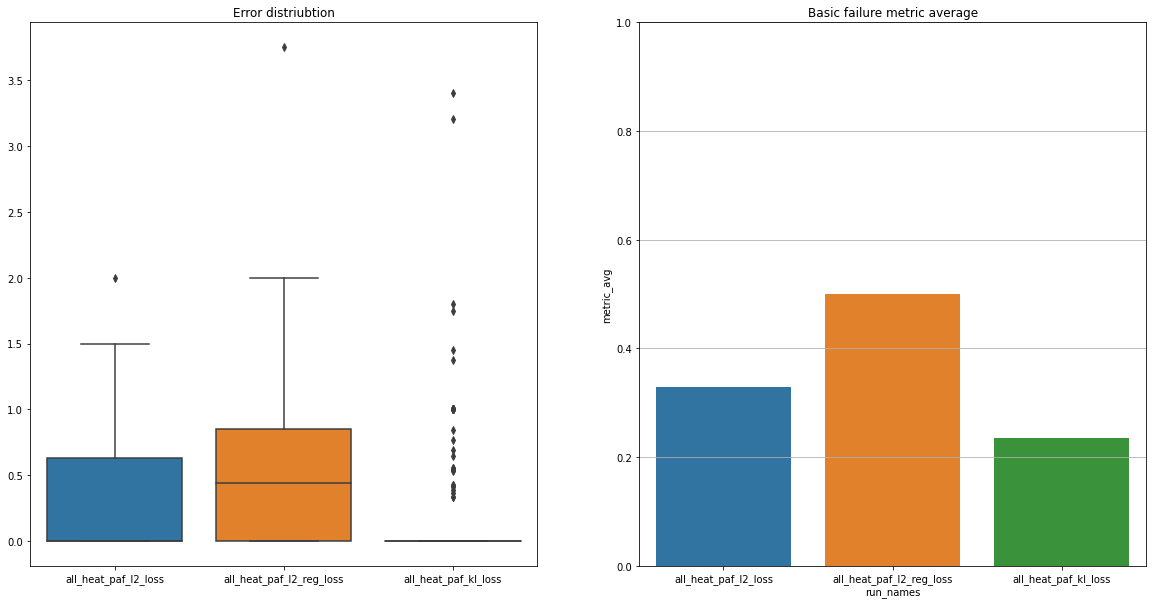

In [37]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax1 = sns.boxplot(data=df, orient="v", ax=ax1)
ax1.set(title = 'Error distriubtion')

df_means = pd.DataFrame({
    "run_names": run_names, 
    "metric_avg": df.mean()
    })
ax2.grid(True)
sns.barplot(x='run_names',  y='metric_avg', data=df_means, orient = 'v', ax=ax2)

ax2.set(title = 'Basic failure metric average')
ax2.set_ylim(0, 1)

fig.savefig("../results/pytorch3d/basic_metric.png")

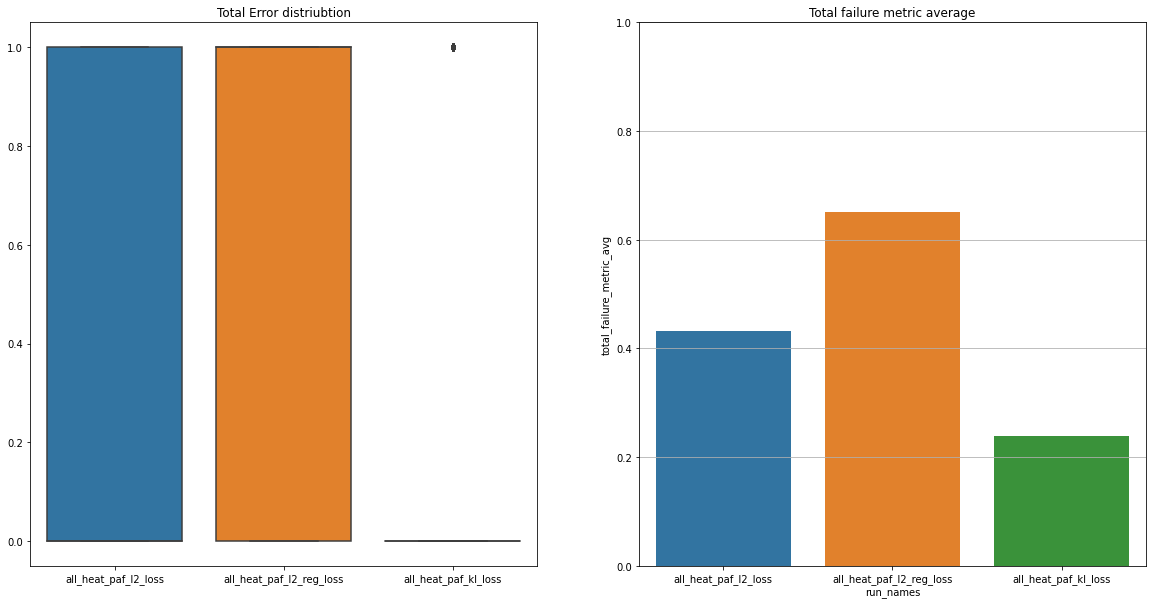

In [38]:
run_names = list(map(lambda c: c.name, Run_types))

df_tf = pd.DataFrame.from_records(
    data=np.transpose(np.array(total_fail_metric_list_list)), 
    columns=run_names
)

df_tf_means = pd.DataFrame({
    "run_names": run_names, 
    "total_failure_metric_avg": df_tf.mean()
    })
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ax1 = sns.boxplot(data=df_tf, orient="v", ax=ax1)
ax1.set(title = 'Total Error distriubtion')

ax2.grid(True)
sns.barplot(x='run_names',  y='total_failure_metric_avg', data=df_tf_means, orient = 'v', ax=ax2)

ax2.set(title = 'Total failure metric average')
ax2.set_ylim(0, 1)
fig.savefig("../results/pytorch3d/total_metric.png")

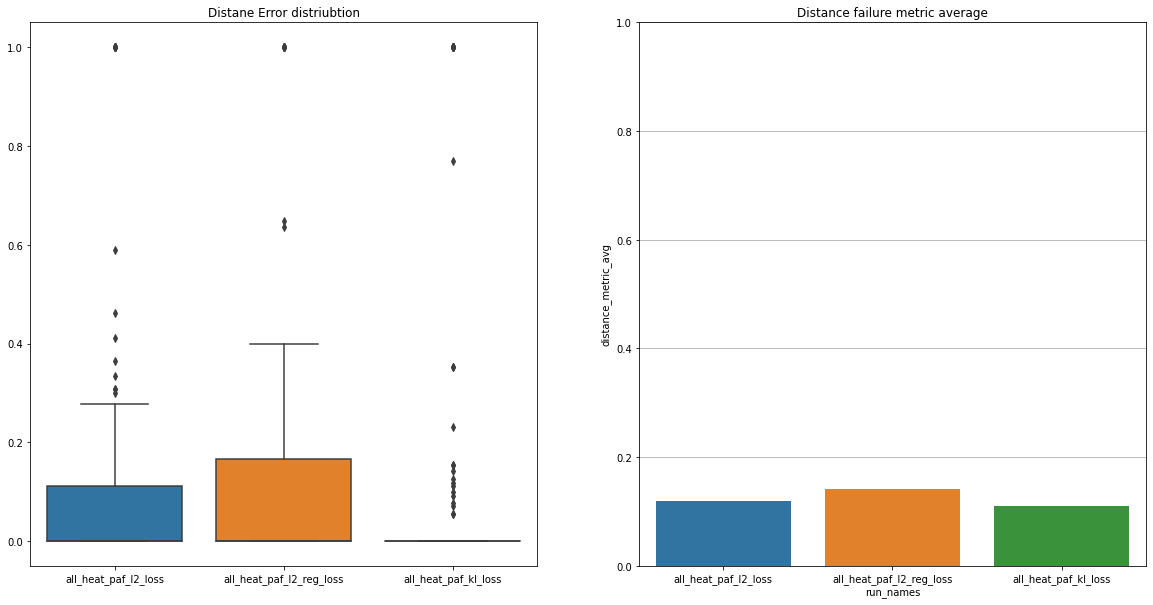

In [39]:
df_dm = pd.DataFrame.from_records(
    data=np.transpose(np.array(distance_metric_list_list)), 
    columns=run_names
)

df_dm_means = pd.DataFrame({
    "run_names": run_names, 
    "distance_metric_avg": df_dm.mean()
    })
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ax1 = sns.boxplot(data=df_dm, orient="v", ax=ax1)
ax1.set(title = 'Distane Error distriubtion')

ax2.grid(True)
sns.barplot(x='run_names',  y='distance_metric_avg', data=df_dm_means, orient = 'v', ax=ax2)

ax2.set(title = 'Distance failure metric average')
ax2.set_ylim(0, 1)
fig.savefig("../results/pytorch3d/distance_metric.png")